In [2]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../AIFT2022_Wiki/config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [3]:
from miscs.config_manager import ConfigManager

In [4]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *
import re

In [5]:
cm = ConfigManager('../AIFT2022_Wiki/config/.config.xml')

In [6]:
print(cm.get_work_path())
print(cm.get_database())
print(cm.get_tables())
print(cm.retrieve_candidate_ETFs())

C:\Users\이연주\Desktop\AIFT\AIFT2022_Wiki
{'database': 'db\\kiwoom_db.sqlite3'}
{'history': {'table_name': 'data_in_minute', 'drop_table': False}, 'today': {'table_name': 'today_in_minute', 'drop_table': True}}
[('069500', 'KONDEX 200', 'X'), ('114800', 'KODEX 인버스', 'Y')]


In [7]:
csv_paths = [ 
  ('069500', r'..\AIFT2022_Wiki\data\kodex_200.csv'),
  ('114800', r'..\AIFT2022_Wiki\data\kodex_inverse.csv'),
  ('226490', r'..\AIFT2022_Wiki\data\kodex_kospi.csv'),
  ('001', r'..\AIFT2022_Wiki\data\kospi.csv'),
  ('201', r'..\AIFT2022_Wiki\data\kospi200.csv')
]

In [8]:
table_info = cm.get_tables()

# 일년치 분봉 데이터 (오늘 제외 = 어제까지의 데이터임)

In [9]:
history_provider = MinuteChartDataProvider.Factory(cm, tag='history')

In [10]:
last_dt = history_provider.query(f"SELECT dt FROM {history_provider.table_name} WHERE st_code='069500' ORDER BY dt DESC LIMIT 1")
print(last_dt)

               dt
0  20221111153500


In [11]:
history_minute_dic = history_provider.get_history_from_ndays_ago(n_days=365)


In [12]:
history_df = history_minute_dic['069500']

In [13]:
history_df

,st_code,open,high,low,close,volume
dt,,,,,,
2021-11-15 09:00:00+09:00,069500,38459,38459,38435,38435,50144
2021-11-15 09:01:00+09:00,069500,38439,38464,38415,38449,23280
2021-11-15 09:02:00+09:00,069500,38454,38488,38454,38469,45724
2021-11-15 09:03:00+09:00,069500,38474,38503,38410,38410,37723
2021-11-15 09:04:00+09:00,069500,38415,38430,38390,38400,16784
...,...,...,...,...,...,...
2022-11-11 15:17:00+09:00,069500,32375,32380,32365,32380,40137
2022-11-11 15:18:00+09:00,069500,32385,32385,32365,32370,34866
2022-11-11 15:19:00+09:00,069500,32365,32380,32365,32380,5633


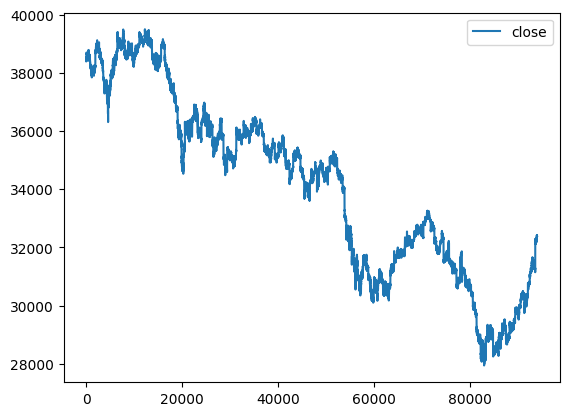

In [14]:
if len(history_df) > 0:
  history_df.plot(use_index=False, y='close')

# 당일 분봉 데이터

In [15]:
today_minute_provider = MinuteChartDataProvider.Factory(cm, tag='today')

In [16]:
today_minute_provider.query(f'select count(*) cnt from {today_minute_provider.table_name}')

,cnt
0,0


In [17]:
today_minute_provider.query(f"SELECT dt FROM {today_minute_provider.table_name} WHERE st_code='069500' ORDER BY dt DESC LIMIT 1")

,dt


In [18]:
# %%timeit
# pd.to_datetime(df['체결시간'], format='%Y%m%d%H%M%S').dt.tz_localize('Asia/Seoul')

In [19]:
for st_code, csv_path in tqdm(csv_paths[:2]):
  df = pd.read_csv(csv_path, dtype={'체결시간':str})
  num_inserted = today_minute_provider.insert_raw_dataframe_data(df, st_code)
  print(f'{st_code} {num_inserted} rows inserted')

  0%|          | 0/2 [00:00<?, ?it/s]

069500 97731 rows inserted
114800 97313 rows inserted


In [20]:
today_minute_dic = today_minute_provider.get_history_from_ndays_ago(n_days=0)
today_df = today_minute_dic['069500']

In [21]:
if len(today_df) > 0:
  today_df.plot(x='dt', y='close')

# 실시간: 주식 체결데이터로부터 분봉 데이터 생성

In [44]:
sample_file_path = r'..\AIFT2022_Wiki\today_069500_minute.txt'
p = re.compile(r".*([{]'code.*[}])")
rt_provider = RealTimeTickDataPrivder.Factory(cm)

In [47]:
with open(sample_file_path, 'r', encoding='utf8') as f:
  for line in f:
    m = p.match(line)
    if m:
      # print(eval(m.group(1)))
      rt_provider.insert_by_query(eval(m.group(1)))

## 조회 쿼리

현재 삽임된 레코드 수 (틱)

In [48]:
rt_provider.query(f'SELECT count(*) cnt FROM {rt_provider.table_name}')

,cnt
0,0


마지막 체결 시각 (틱)

In [49]:
rt_provider.recent_inserted_ts()

IndexError: list index out of range

존재하는 테이블 조회

In [50]:
rt_provider.query('select name from sqlite_master where type="table"')

,name
0,today_in_ticks


틱을 분봉으로 조회하는 쿼리

In [51]:
real_minute_df = rt_provider.make_minute_chart_df()

In [52]:
real_minute_df.query("st_code=='069500'").plot(use_index=False, y='close')

TypeError: no numeric data to plot

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=real_minute_df.query("st_code=='069500'")['dt'],
                open=real_minute_df.query("st_code=='069500'")['open'],
                high=real_minute_df.query("st_code=='069500'")['high'],
                low=real_minute_df.query("st_code=='069500'")['low'],
                close=real_minute_df.query("st_code=='069500'")['close'])])
fig.show()

# 결합 테스트

스태틱 소스
- 어제까지 확보한 분봉 데이터 (TR 요청):: db/kiwoom_db.sqlite3:data_in_minute
- 오늘 장중에 확보한 분봉 데이터 (TR 요청):: db/kiwoom_db.sqlite3:today_in_minute
    - 장해 등으로 장중 (예: 11시)에 재접속 시 생성
        - TR요청으로 수집 

동적 소스
- 오늘 실시간 틱 데이터:: 인메모리 디비:today_in_ticks
- 오늘 틱 데이터로부터 생성한 분봉 데이터:: 인메모리 디비:today_in_minute 

결합
- `정적저장소`:data_in_minute + today_in_minute + `인메모리`:today_in_minute

In [53]:
provider.query(f"select count(*) from {provider.table_name}")

NameError: name 'provider' is not defined

In [54]:
merged_df = pd.concat((history_df.query("st_code=='069500'"),
today_df.query('st_code=="069500"')), ignore_index=True)

In [55]:
merged_df.head()

,st_code,open,high,low,close,volume
0,069500,38459,38459,38435,38435,50144
1,069500,38439,38464,38415,38449,23280
2,069500,38454,38488,38454,38469,45724
3,069500,38474,38503,38410,38410,37723
4,069500,38415,38430,38390,38400,16784


## 의의로...  SQLite3 -> Pandas 로딩후 dt를 Timestamp 변환시 시간 걸림

- 2000 행에 대해 요청시, 399ms 걸림

In [56]:
pd.to_datetime(merged_df[-2000:]['dt'], format='%Y%m%d%H%M%S')

KeyError: 'dt'

작전
- 장시작전: 어제까지의 분봉 데이터는 SQL -> pd.DataFrame 변환 해 둔다. (DataProvider 역할)
- 장중: 오늘의 분봉 데이터를 SQlite3 -> pd.DataFrame 변환한다. (DataProvider 역할)
- 합친다.